In [310]:
# Basic system libraries
import os.path
import glob
import tempfile
from io import BytesIO, StringIO
import re
from collections import Counter
import dill

# Additional libraries for web, archives and parallel execution
import requests
import json
import tarfile
import tqdm
from joblib import Parallel, delayed

# Basic scientific staff
import numpy as np
import pandas as pd

# Libraries for visualization
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import matplotlib.ticker
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D

# Library for 3D structures
import prody

# Library to read fasta files
import pyfastx

In [16]:
# Set species ID

species = [
    9606, # Homo sapiens
    10090, # Mus musculus

    7227, # Drosophila melanogaster
    6239, # Caenorhabditis elegans

    559292, # Saccharomyces cerevisiae
    284812, # Schizosaccharomyces pombe

    83333, # Escherichia coli
    93061, # Staphylococcus aureus
    36329, # Plasmodium falciparum  
    83332, # Mycobacterium tuberculosis
    
    3702, # Arabidopsis thaliana
]  

data = dict()

for specid in species:
    data[specid] = {
    # Raw uniprot data for the given proteome
    'udata_raw': None,
    # Uniprot data only for sequences in the reference proteome
    'udata': None,
    # All isoforms
    'smdata_raw': None,
    # Only canonical isoforms from the reference proteome
    'smdata': None,
    # Total number of residues covered by the SwissModel
    'smtotal': 0,
    # pLDDT data
    'plddt': None,
    # AlphaFold data
    'afdata': None,
    # New data added by the AlphaFold
    'newdata': None,
    # Bad IDs (mismatches between uniprot and AF)
    'badids': None,

}


nsp = len(species)

# Set path to the unarchived repository of the corresponding species
afdbpath = '/mnt/scratch/alphafold.ebi.ac.uk/by-id/' 

In [17]:
# Download Index of reference proteomes
purl = 'https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/README'
preq = requests.get(purl)
rawdata = preq.text.split("\n")

In [18]:
# Find where the proteome list begins

ib = None
ie = None

for i, line in enumerate(rawdata):
    if re.match('Proteome_ID', line):
        ib = i
    if line == '' and ib is not None:
        ie = i
        break
    
# parse only proteome data
proteomes = pd.read_csv(StringIO('\n'.join(rawdata[ib:ie])), delimiter='\t')

In [19]:
proteomes

,Proteome_ID,Tax_ID,OSCODE,SUPERREGNUM,#(1),#(2),#(3),Species Name
0,UP000289406,2069326,None,viruses,2,0,2,Medicago sativa amalgavirus 1
1,UP000320513,2592811,None,bacteria,5147,0,5149,Mycobacterium helveticum
2,UP000236569,200253,None,bacteria,4445,0,4446,Deinococcus aerius
3,UP000326946,2652407,None,viruses,56,0,56,Microbacterium phage PhriedRice
4,UP000296946,2548089,None,viruses,52,0,52,Streptococcus phage Javan274
...,...,...,...,...,...,...,...,...
20110,UP000243650,1548213,None,bacteria,3136,0,3140,Bacillus urumqiensis
20111,UP000509302,343403,None,bacteria,3525,0,3527,Costertonia aggregata
20112,UP000011203,102125,None,bacteria,5347,0,5372,Xenococcus sp. PCC 7305
20113,UP000008366,1184609,None,bacteria,4422,0,4422,Kineosphaera limosa NBRC 100340


In [20]:
# Extract species names
spnames = [proteomes[proteomes['Tax_ID'] == specid]['Species Name'].values[0] for specid in species]

In [21]:
def format_spname(spname, short=True):
    """
    Reformat names for future usage in gpaphs
    From: 'Homo sapiens (Human)'
    To: 'Homo sapiens\n(Human)'
    """
    newname_ = list()
    spname_ = spname.split(' ')
    part = None
    for i in range(len(spname_)):
        p = spname_[i]
        if part is None:
            part = list()

        if p[0] == "(":
            newname_.append(part)
            part = list()

        part.append(p)

    if len(part) > 0:
        newname_.append(part)
    
    if short is True:
        newname = ' '.join(newname_[0])
    else:
        newname = '\n'.join([' '.join(x) for x in newname_])
        
    return(newname)

spnames_formatted = [format_spname(x) for x in spnames]

In [22]:
spnames_formatted

['Homo sapiens',
 'Mus musculus',
 'Drosophila melanogaster',
 'Caenorhabditis elegans',
 'Saccharomyces cerevisiae',
 'Schizosaccharomyces pombe',
 'Escherichia coli',
 'Staphylococcus aureus',
 'Plasmodium falciparum',
 'Mycobacterium tuberculosis',
 'Arabidopsis thaliana']

In [23]:
# Read metadata from Uniprot

for i in tqdm.trange(nsp):
    # Get info about taxon
    
    specid = species[i]
    spname = spnames[i]
    proteome_ = proteomes[proteomes['Tax_ID'] == specid]
    proteome_id = proteome_['Proteome_ID'].values[0]
    taxon = proteome_['SUPERREGNUM'].values[0].capitalize()
    
    print(specid, spname, proteome_id, taxon)
    
    # Download reference proteome for specid
    pgz = "%s_%s.fasta.gz" % (proteome_id, specid)
    purl_f = "https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/%s/%s/%s" 
    purl_ =  purl_f % (taxon, proteome_id, pgz)
    
    # Do everything in temp dir, which will be safely discarded later
    with tempfile.TemporaryDirectory() as tmpdirname:

        # Download SwissModel repo metadata
        preq = requests.get(purl_)
        fname = os.path.join(tmpdirname, pgz)

        with open(fname, 'wb') as f:
            f.write(preq.content)
        
        # Extract sequence names from the reference proteome
        unames_ = list()
        for name, seq in pyfastx.Fasta(fname, build_index=False):
            unames_.append(name)
    
    # Store seqnames as pandas dataframe
    unames = pd.read_csv(StringIO('\n'.join(unames_)), delimiter='|', header=None, names=['Bank', 'Entry', 'Entry name'])
    
    # Download extended data from Unirpot
    uurl_f = 'https://www.uniprot.org/uniprot/?query=proteome:%s&columns=id,entry name,reviewed,protein names,genes,organism,length,sequence,database(Pfam),feature(DOMAIN EXTENT)&format=tab'
    uurl = uurl_f % proteome_id
    
    ureq = requests.get(uurl)
    udata = pd.read_csv(BytesIO(ureq.content), delimiter='\t')
    
    # Store raw and filtered records
    data[specid]['udata_raw'] = udata
    data[specid]['udata'] = udata[udata['Entry'].isin(unames['Entry'])]

  0%|          | 0/11 [00:00<?, ?it/s]

9606 Homo sapiens (Human) UP000005640 Eukaryota


  9%|▉         | 1/11 [00:23<03:54, 23.50s/it]

10090 Mus musculus (Mouse) UP000000589 Eukaryota


 18%|█▊        | 2/11 [00:55<04:18, 28.72s/it]

7227 Drosophila melanogaster (Fruit fly) UP000000803 Eukaryota


 27%|██▋       | 3/11 [01:37<04:37, 34.72s/it]

6239 Caenorhabditis elegans UP000001940 Eukaryota


 36%|███▋      | 4/11 [02:08<03:52, 33.15s/it]

559292 Saccharomyces cerevisiae (strain ATCC 204508 / S288c) (Baker's yeast) UP000002311 Eukaryota


 45%|████▌     | 5/11 [02:15<02:21, 23.64s/it]

284812 Schizosaccharomyces pombe (strain 972 / ATCC 24843) (Fission yeast) UP000002485 Eukaryota


 55%|█████▍    | 6/11 [02:23<01:32, 18.52s/it]

83333 Escherichia coli (strain K12) UP000000625 Bacteria


 64%|██████▎   | 7/11 [02:32<01:01, 15.29s/it]

93061 Staphylococcus aureus (strain NCTC 8325 / PS 47) UP000008816 Bacteria


 73%|███████▎  | 8/11 [02:41<00:39, 13.27s/it]

36329 Plasmodium falciparum (isolate 3D7) UP000001450 Eukaryota


 82%|████████▏ | 9/11 [02:54<00:26, 13.26s/it]

83332 Mycobacterium tuberculosis (strain ATCC 25618 / H37Rv) UP000001584 Bacteria


 91%|█████████ | 10/11 [03:04<00:12, 12.33s/it]

3702 Arabidopsis thaliana (Mouse-ear cress) UP000006548 Eukaryota


100%|██████████| 11/11 [03:54<00:00, 21.35s/it]


In [24]:
# Example output
udata

,Entry,Entry name,Status,Protein names,Gene names,Organism,Length,Sequence,Cross-reference (Pfam),Domain [FT]
0,Q93VR4,ML423_ARATH,reviewed,MLP-like protein 423,MLP423 At1g24020 T23E23.17 T23E23_22,Arabidopsis thaliana (Mouse-ear cress),155,MGLSGVLHVEVEVKSPAEKFWVALGDGINLFPKAFPNDYKTIQVLA...,PF00407;,NaN
1,Q9ZUA3,MP703_ARATH,reviewed,Microtubule-associated protein 70-3 (AtMAP70-3...,MAP70.3 At2g01750 T8O11.8,Arabidopsis thaliana (Mouse-ear cress),629,MEEGGYAFEVNNGRPTASEFGTTARISSPSLTMSSSFREGGGGGGS...,PF07058;,NaN
2,Q9M0T3,MP3K3_ARATH,reviewed,Mitogen-activated protein kinase kinase kinase...,MEKK3 MAP3Kb3 MAPKKK10 At4g08470 T15F16.2,Arabidopsis thaliana (Mouse-ear cress),560,MDVTAIFAGDILVQSREYLIPNDVVDVDGGIKAVRPPIIQPPPGRK...,PF00069;,"DOMAIN 303..557; /note=""Protein kinase""; /ev..."
3,Q84LK0,MSH1_ARATH,reviewed,"DNA mismatch repair protein MSH1, mitochondria...",MSH1 CHM CHM1 At3g24320 K7M2.9,Arabidopsis thaliana (Mouse-ear cress),1118,MHWIATRNAVVSFPKWRFFFRSSYRTYSSLKPSSPILLNRRYSEGI...,PF01541;PF01624;PF00488;,NaN
4,Q94AT1,P2C76_ARATH,reviewed,Probable protein phosphatase 2C 76 (AtPP2C76) ...,At5g53140 MFH8.8,Arabidopsis thaliana (Mouse-ear cress),420,MVCSSFIRSFIVQAGCRIGVLAQGRHQFIHIKKTLSVGFGFRTSVI...,PF00481;,"DOMAIN 101..347; /note=""PPM-type phosphatase""..."
...,...,...,...,...,...,...,...,...,...,...
39332,A0A1P8AWW6,A0A1P8AWW6_ARATH,unreviewed,Alpha/beta-Hydrolases superfamily protein,BDG1 BODYGUARD1 CED1 At1g64670 F1N19.24 F1N19_24,Arabidopsis thaliana (Mouse-ear cress),524,MLNAINKFMQLPSVFLSLFINLISLSHAFCLCNITTIHTYNLHTYT...,PF00561;,"DOMAIN 240..372; /note=""AB hydrolase-1""; /ev..."
39333,A0A1I9LP15,A0A1I9LP15_ARATH,unreviewed,Receptor like protein 44,RLP44 AtRLP44 receptor like protein 44 At3g49750,Arabidopsis thaliana (Mouse-ear cress),188,MTRSHRLLLLLLLIFQTAQRLTTADPNDEACLKNLRQNLEDPASNL...,PF13855;,NaN
39334,A0A1I9LN71,A0A1I9LN71_ARATH,unreviewed,TRAF-like family protein,At3g46190,Arabidopsis thaliana (Mouse-ear cress),311,MEKDAIKEEEIISNDLLWKKADIKEESDISEGSQKHEKLKTALLPY...,PF00917;,"DOMAIN 52..156; /note=""MATH""; /evidence=""ECO..."
39335,A0A1I9LQN1,A0A1I9LQN1_ARATH,unreviewed,Cysteine/Histidine-rich C1 domain family protein,At3g27500,Arabidopsis thaliana (Mouse-ear cress),545,MTYELEELEGHEHLVSRVKHHDGLECDACDRLNVDGYSCSECKFNI...,PF03107;,"DOMAIN 127..174; /note=""Phorbol-ester/DAG-typ..."


In [28]:
# Read metadata from SwissModel

for i in tqdm.trange(nsp):
    specid = species[i]
    udata = data[specid]['udata'] 
    smgz = "%d_meta.tar.gz" % specid

    # Do everything in temp dir, which will be safely discarded later
    with tempfile.TemporaryDirectory() as tmpdirname:

        # Download SwissModel repo metadata
        smreq = requests.get("https://swissmodel.expasy.org/repository/download/core_species/%s" % smgz)
        fname = os.path.join(tmpdirname, smgz)

        with open(fname, 'wb') as f:
            f.write(smreq.content)

        # Unpack key INDEX.json file
        with tarfile.open(fname, "r:gz") as f:
            f.extract('SWISS-MODEL_Repository/INDEX.json', path=tmpdirname)

        # Read INDEX.json as pandas dataframe
        fname = os.path.join(tmpdirname, 'SWISS-MODEL_Repository/INDEX.json')

        with open(fname, 'rb') as f:
            smdata_ = json.load(f)
            smdata__ = pd.DataFrame(smdata_['index'])

    smdata = smdata__[smdata__['uniprot_ac'].isin(udata['Entry']) & (smdata__['provider'] == 'SWISSMODEL')]
    
    data[specid]['smdata_raw']= smdata__
    data[specid]['smdata'] = smdata

100%|██████████| 11/11 [00:15<00:00,  1.41s/it]


In [29]:
# Example output
smdata

,uniprot_ac,iso_id,uniprot_seq_length,uniprot_seq_md5,coordinate_id,provider,from,to,template,qmeandisco_global,seqid,url
0,P48347,P48347-1,254,5d6fcbc294f21b6fc338751bba3f4562,60ea3ff87451f83c2b9e6b26,SWISSMODEL,4,233,2br9.1.B,0.833222,73.81974,https://swissmodel.expasy.org/repository/unipr...
2,Q9S9Z8,Q9S9Z8-1,252,a9460686f3527453337806c8b1bafaee,60ea4601e61fd243012494dd,SWISSMODEL,4,233,2br9.1.B,0.853558,75.536484,https://swissmodel.expasy.org/repository/unipr...
5,Q9C5W6,NaN,268,567d6c3b0189062f3c257e53c5717129,60ea187bfd38e19a3e12d9bc,SWISSMODEL,9,238,2br9.1.B,0.851179,76.394852,https://swissmodel.expasy.org/repository/unipr...
6,P42643,P42643-1,267,8786ea8a093ba8f1513e0f497fa1ec1b,61064eb0090411273da1ac68,SWISSMODEL,9,240,2br9.1.B,0.871835,76.394852,https://swissmodel.expasy.org/repository/unipr...
7,Q01525,NaN,259,7a832e927a039b8480300261dac30c1d,60ea32a60156c2cde1046a33,SWISSMODEL,4,235,2br9.1.B,0.878774,77.25322,https://swissmodel.expasy.org/repository/unipr...
...,...,...,...,...,...,...,...,...,...,...,...,...
39749,F4JY62,NaN,131,8337b71f7bd0f8f772ec532a7d6be2ac,60ec10364c0876dc7a67d15c,SWISSMODEL,66,122,2p2u.2.A,0.708153,14.035088,https://swissmodel.expasy.org/repository/unipr...
39750,A0A1P8B4A5,NaN,725,21784d73103b67105a6c332f0d73db6c,60ec573401633421bbe941a5,SWISSMODEL,39,315,5dbx.1.A,0.676980,50.180504,https://swissmodel.expasy.org/repository/unipr...
39751,A0A1P8B4A5,NaN,725,21784d73103b67105a6c332f0d73db6c,60ec573401633421bbe941a9,SWISSMODEL,49,359,4red.1.C,0.505068,30.240549,https://swissmodel.expasy.org/repository/unipr...
39752,A0A1P8B4A5,NaN,725,21784d73103b67105a6c332f0d73db6c,60ec573401633421bbe941ad,SWISSMODEL,49,352,3igo.1.A,0.603308,28.522337,https://swissmodel.expasy.org/repository/unipr...


In [31]:
# Read pLDDT scores from local database
for specid in species:
    afnames = glob.glob(os.path.join(afdbpath, str(specid), '*.cif.gz'))

    def extract_plddt_from_cif(fname):
        ac = os.path.basename(fname).split('-')[1]
        pdb, header = prody.parseMMCIF(fname, subset='ca', header=True)
        b = int(header[0].search('_ma_target_ref_db_details.seq_db_align_begin').data[0])
        e = int(header[0].search('_ma_target_ref_db_details.seq_db_align_end').data[0])
        plddt = pdb.getBetas()
        seq = pdb.getSequence()

        return((ac, b, e, plddt, seq))

    # Use parallel processing to speedup things
    plddt_all_ = Parallel(n_jobs=-1, verbose=1)(delayed(extract_plddt_from_cif)(fname) for fname in afnames)
    data[specid]['plddt'] = plddt_all_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 544 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 994 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1544 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 2194 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 2944 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 3794 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 4744 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 5794 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 6944 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 8194 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 9544 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 10994 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 12544 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 14194 tasks  

In [32]:
# Cleanup and store final AlphaFold data

for i in tqdm.trange(nsp):
    specid = species[i]
    plddt_data = data[specid]['plddt']
    afdata_ = dict()
    

    for r in plddt_data:
        ac, b, e, plddt, seq = r

        if ac not in afdata_:
            afdata_[ac] = {
                'ac': ac,
                'frags': list()
            }

        afdata_[ac]['frags'].append((b, e, plddt, seq))

    # Merge pLDDT for fragments
    afdata__ = list()

    for ac in afdata_.keys():

        # guess protein length only from unsorted records
        # this might not the optimal way, but the most generic one
        L = 0
        for frag in afdata_[ac]['frags']:
            b, e, plddt_, seq_ = frag
            L = max(L, e)

        # Create an array to store pLDDT scores
        plddt = np.zeros(L)
        seq = np.empty(L, dtype='U1')

        # Now select best pLDDT score per residue from all frags
        for frag in afdata_[ac]['frags']:
            b, e, plddt_, seq_ = frag
            plddt[b - 1: e] = np.maximum(plddt[b - 1:e], plddt_)
            seq[b - 1: e] = list(seq_)

        # Store as simple list for compatibility with pandas
        d_ = {
            'uniprot_ac': ac,
            'pLDDT': plddt,
            'length': len(plddt),
            'sequence': ''.join(seq)
        }
        afdata__.append(d_)

    afdata = pd.DataFrame(afdata__)
    data[specid]['afdata'] = afdata

100%|██████████| 11/11 [00:15<00:00,  1.37s/it]


In [33]:
# Example output
afdata

,uniprot_ac,pLDDT,length,sequence
0,A0A0A7EPL0,"[61.39, 62.26, 63.1, 61.71, 59.13, 59.14, 54.3...",847,MVIPATSRFGFRAEFNTKEFQASCISLANEIDAAIGRNEVPGNIQE...
1,A0A140JWM8,"[76.72, 83.99, 85.68, 87.14, 87.88, 88.99, 89....",473,MYLTIIFLFISSIIFPLLFFLGKHLSNFRYPNLPPGKIGFPLIGET...
2,A0A178U7J2,"[29.28, 31.6, 27.8, 33.2, 35.34, 30.72, 33.25,...",385,MRRIFLFDENSLNSSSTIDTSSASTIDTSFASQCTNFSSGQASGTQ...
3,A0A178U9T0,"[55.5, 64.26, 74.79, 76.59, 83.98, 86.37, 88.8...",74,MATKISHLVSLLLSLLLLLLFISSQVGFTEAKRDERKKMSSPPIPS...
4,A0A178UFC4,"[41.7, 44.09, 49.86, 47.08, 56.9, 48.14, 54.69...",113,MDRVLADNRRQSYSTGRCLSSPLSCLIHTEETEYARISNHNNKTRP...
...,...,...,...,...
27429,Q9ZWT1,"[35.02, 34.07, 31.02, 30.59, 37.51, 31.38, 37....",374,MHSRSALLYRFLRPASRCFSSSSAVTPVTVTQSPKSLEALRARLAN...
27430,Q9ZWT2,"[43.37, 48.94, 53.83, 61.54, 74.6, 92.42, 94.9...",140,MGGDGKVFTLSEVSQHSSAKDCWIVIDGKVYDVTKFLDDHPGGDEV...
27431,Q9ZWT3,"[36.87, 32.59, 36.93, 41.9, 50.05, 49.16, 63.0...",516,MANEEQGSILKALDVAKTQWYHVTAVVVSGMGFFTDSYDLFVISLI...
27432,X5JA13,"[28.7, 33.18, 29.52, 31.82, 29.13, 29.52, 28.5...",825,MTEGIRARGPRSSSVNSVPLILDIEDFKGDFSFDALFGNLVNDLLP...


In [35]:
newdata_all = dict()
smtotal_all = dict()

for i in range(nsp):
    
    specid = species[i]
    spname = spnames[i]
    
    badids = list()
    
    udata = data[specid]['udata']
    smdata = data[specid]['smdata']
    afdata = data[specid]['afdata']
    
    uset = set(udata['Entry']) 
    smset = set(smdata['uniprot_ac'])
    afset = set(afdata['uniprot_ac'])

    # Select common part of SwissModel and AlphaFold
    tset1 = (smset & afset)

    # Select new part of  AlphaFold
    tset2 = (smset ^ afset) & afset

    # Select only ACs from the reviewed Uniprot part
    usmafcomp = list((tset1 | tset2) & uset)
    smtotal = 0
    newdata_ = list()

    print('#' * 40)
    print(spname)
    
    for ac in tqdm.tqdm(usmafcomp):
        # Extract reference length from Uniprot
        udata_ = udata[udata['Entry'] == ac]
        ul = udata_['Length'].values[0]
        useq = udata_['Sequence'].values[0]

        # There can be multiple models per AC
        smdata_ = smdata[smdata['uniprot_ac'] == ac]

        # Extract pLDDT
        afdata_ = afdata[afdata['uniprot_ac'] == ac]
        plddt = afdata_['pLDDT'].values[0]
        al = afdata_['length'].values[0]
        aseq = afdata_['sequence'].values[0]

        if ul != al:
            badids.append(ac)
            print('Found length mismatch: %s %d %d' % (ac, ul, al))
            continue

        if useq != aseq:
            badids.append(ac)
            print('Found seq mismatch: %s' % (ac))
            continue

        if len(smdata_) ==  0:

            d_ = {
                'uniprot_ac': ac,
                'fragnum': 0,
                'from': 1,
                'to': ul,
                'length': len(plddt),
                'pLDDT': plddt,
                'pLDDT_min': np.min(plddt_),
                'pLDDT_med': np.median(plddt_),
                'pLDDT_max': np.max(plddt_),
                'sequence': aseq,
            }

            newdata_.append(d_)

            # Since there is no SwissModel data
            # just switch to the next AC
            continue

        coverage = np.zeros(ul)
        breaks = list()

        for index, row in smdata_.iterrows():

            b = row['from']
            e = row['to']

            coverage[b - 1: e] = 1

        smtotal += np.sum(coverage)
        
        # Naive break search
        b_ = False
        bb_ = None
        be_ = None

        for i in range(ul):
            if coverage[i] == 0:
                if b_ is False:
                    b_ = True
                    # pdb starts with 1
                    bb_ = i + 1 
                elif b_ is True:
                    pass
            elif coverage[i] == 1 and b_ is True:
                be_ = i # already i + 1
                breaks.append((bb_, be_))
                b_ = False

        # Check the missing C-terminus
        if b_ is True:
            breaks.append((bb_, i + 1))
            b_ = False

        for i, b in enumerate(breaks):
            bb_, be_ = b
            plddt_ = plddt[bb_ - 1:be_]
            seq_ = aseq[bb_ - 1:be_]

            d_ = {
                'uniprot_ac': ac,
                'fragnum': i,
                'from': bb_,
                'to': be_,
                'length': len(plddt_),
                'pLDDT': plddt_,
                'pLDDT_min': np.min(plddt_),
                'pLDDT_med': np.median(plddt_),
                'pLDDT_max': np.max(plddt_),
                'sequence': seq_,
            }

            newdata_.append(d_)

    data[specid]['smtotal'] = smtotal
            
    newdata = pd.DataFrame(newdata_)
    data[specid]['newdata'] = newdata
    data[specid]['badids'] = badids

  0%|          | 13/20481 [00:00<02:43, 125.12it/s]

########################################
Homo sapiens (Human)


 17%|█▋        | 3408/20481 [00:25<02:14, 126.78it/s]

Found length mismatch: Q8WYJ6 372 367


 29%|██▉       | 6020/20481 [00:45<01:44, 138.56it/s]

Found length mismatch: Q9Y2G2 537 431


 62%|██████▏   | 12800/20481 [01:34<00:56, 136.53it/s]

Found seq mismatch: P11586


 70%|██████▉   | 14243/20481 [01:45<00:45, 137.75it/s]

Found length mismatch: Q04741 290 257


  0%|          | 14/21590 [00:00<02:43, 131.74it/s]

########################################
Mus musculus (Mouse)


  3%|▎         | 574/21590 [00:04<02:34, 136.15it/s]

Found length mismatch: P30545 453 450


  6%|▌         | 1316/21590 [00:09<02:28, 136.55it/s]

Found seq mismatch: Q9D9G2


 14%|█▍        | 3108/21590 [00:23<02:16, 135.81it/s]

Found seq mismatch: E9PWW6


 17%|█▋        | 3726/21590 [00:27<02:13, 134.08it/s]

Found length mismatch: E9PWP7 4499 378


 36%|███▋      | 7856/21590 [00:58<01:42, 134.11it/s]

Found seq mismatch: F7B5D6


 56%|█████▌    | 12028/21590 [01:29<01:11, 134.05it/s]

Found seq mismatch: B8JJD3


 94%|█████████▍| 20317/21590 [02:31<00:09, 132.48it/s]

Found length mismatch: Q8BXQ6 823 817


 99%|█████████▊| 21296/21590 [02:39<00:02, 131.27it/s]

Found length mismatch: Q80XA6 647 521


  0%|          | 29/13457 [00:00<00:46, 288.94it/s]

########################################
Drosophila melanogaster (Fruit fly)


  0%|          | 23/19657 [00:00<01:25, 229.63it/s]

########################################
Caenorhabditis elegans


  4%|▎         | 694/19657 [00:03<01:22, 228.96it/s]

Found length mismatch: Q95XZ5 2176 2203


 18%|█▊        | 3455/19657 [00:14<01:10, 229.98it/s]

Found length mismatch: A7LPG2 194 209


 22%|██▏       | 4249/19657 [00:18<01:05, 235.00it/s]

Found length mismatch: Q9XVM4 70 57


 44%|████▍     | 8680/19657 [00:37<00:47, 231.41it/s]

Found length mismatch: Q7YWN9 138 162


 45%|████▌     | 8848/19657 [00:37<00:47, 229.71it/s]

Found length mismatch: Q9XWG8 220 257


 48%|████▊     | 9437/19657 [00:40<00:44, 228.81it/s]

Found length mismatch: Q9N3T3 221 230


 55%|█████▍    | 10753/19657 [00:46<00:40, 220.84it/s]

Found length mismatch: P90933 228 208


 59%|█████▉    | 11621/19657 [00:50<00:48, 167.36it/s]

Found length mismatch: P34306 234 371


 59%|█████▉    | 11693/19657 [00:50<00:46, 170.85it/s]

Found length mismatch: Q93364 96 156


 60%|█████▉    | 11784/19657 [00:51<00:45, 173.59it/s]

Found length mismatch: A0A2C9C2W3 45 68


 63%|██████▎   | 12452/19657 [00:55<00:42, 169.02it/s]

Found length mismatch: O76623 891 883


 74%|███████▍  | 14627/19657 [01:07<00:27, 184.66it/s]

Found length mismatch: Q9N5L9 1412 1427


 82%|████████▏ | 16086/19657 [01:15<00:19, 179.94it/s]

Found length mismatch: Q09277 1229 1288


 84%|████████▎ | 16452/19657 [01:17<00:17, 180.97it/s]

Found length mismatch: L8E7Z4 297 262


 88%|████████▊ | 17295/19657 [01:21<00:12, 193.85it/s]

Found length mismatch: Q11071 220 210


 94%|█████████▍| 18481/19657 [01:28<00:06, 185.84it/s]

Found length mismatch: P34430 254 244


100%|█████████▉| 19559/19657 [01:33<00:00, 189.20it/s]

Found length mismatch: Q11089 453 211
Found length mismatch: P34590 421 306


  1%|          | 51/6040 [00:00<00:11, 505.28it/s]

########################################
Saccharomyces cerevisiae (strain ATCC 204508 / S288c) (Baker's yeast)


  1%|          | 46/5128 [00:00<00:11, 453.21it/s]

########################################
Schizosaccharomyces pombe (strain 972 / ATCC 24843) (Fission yeast)


  1%|▏         | 57/4363 [00:00<00:07, 559.60it/s]

########################################
Escherichia coli (strain K12)


  2%|▏         | 68/2888 [00:00<00:04, 676.89it/s]

########################################
Staphylococcus aureus (strain NCTC 8325 / PS 47)


  1%|          | 57/5186 [00:00<00:09, 560.89it/s]

########################################
Plasmodium falciparum (isolate 3D7)


  2%|▏         | 60/3988 [00:00<00:06, 599.29it/s]

########################################
Mycobacterium tuberculosis (strain ATCC 25618 / H37Rv)


  0%|          | 15/27424 [00:00<03:09, 144.65it/s]

########################################
Arabidopsis thaliana (Mouse-ear cress)


 29%|██▉       | 7887/27424 [00:56<02:13, 146.10it/s]

Found length mismatch: F4HTB2 48 109


 59%|█████▉    | 16294/27424 [01:54<01:17, 142.88it/s]

Found length mismatch: Q8H0T5 262 211


100%|██████████| 27424/27424 [03:12<00:00, 142.37it/s]


In [36]:
newdata

,uniprot_ac,fragnum,from,to,length,pLDDT,pLDDT_min,pLDDT_med,pLDDT_max,sequence
0,F4HYU6,0,1,14,14,"[56.32, 69.46, 73.1, 72.94, 69.9, 72.74, 72.91...",56.32,72.825,86.94,MSNHQTKQVLKQLE
1,F4HYU6,1,279,282,4,"[44.53, 47.96, 44.01, 37.2]",37.20,44.270,47.96,FSSL
2,O04034,0,1,546,546,"[40.77, 40.89, 45.65, 44.76, 52.3, 53.61, 57.0...",37.20,44.270,47.96,MELISSSTIGNSALCLTLISILIFFFLTTTTIPTFPDHPLRSLLDD...
3,A0A1P8B7J5,0,1,11,11,"[56.03, 63.46, 65.89, 70.72, 78.74, 75.35, 78....",56.03,78.740,80.95,MWYPLYFLIHL
4,A0A1P8B7J5,1,57,67,11,"[76.99, 72.56, 72.24, 63.47, 62.16, 62.61, 60....",49.15,62.160,76.99,DRTSMIDLGGS
...,...,...,...,...,...,...,...,...,...,...
44700,Q9LXN3,0,1,493,493,"[46.89, 57.92, 69.0, 87.14, 91.88, 92.97, 93.0...",28.82,31.720,52.59,MDSNCIQFLHDKTILVTGVPGFLAKVFVEKILRIQPKVKKLFLLLR...
44701,Q9FNN8,0,1,590,590,"[37.21, 33.27, 35.32, 34.93, 30.4, 29.68, 27.3...",28.82,31.720,52.59,MASPAGETAAVVEGGDGQQQRQAGGFGQTITGIIRIAVFCYFASKF...
44702,Q9SJM3,0,1,553,553,"[32.44, 30.44, 31.52, 37.5, 33.64, 30.06, 32.4...",26.00,35.070,91.61,MESFAGSCEIVEEKDAVRLAKHSSRYCMSPLGSSKDMEQRPALKSG...
44703,Q9SJM3,1,923,949,27,"[31.36, 29.24, 37.04, 33.56, 37.87, 36.85, 31....",25.52,30.280,37.87,TEATSPEGNNRYLECKAIGDHLEFELF


In [124]:
for i in range(nsp):
    specid = species[i]
    spname = spnames[i]
    print(spname)
    udata = data[specid]['udata']
    smdata = data[specid]['smdata']
    smtotal = data[specid]['smtotal']
    afdata = data[specid]['afdata']
    newdata = data[specid]['newdata']
    
    print('#' * 40)
    print('Total Unpritot size (proteins): %d' % len(udata))
    ucompletel = np.sum(udata['Length'])
    print('Total Unpritot size (aa): %d' % ucompletel)

    smcomplete = smdata[(smdata['from'] == 1) & 
                        (smdata['to'] == smdata['uniprot_seq_length'])]
    print('Complete models in SwissModel (proteins): %d' % len(smcomplete))

    smcompletel = np.sum(smcomplete['uniprot_seq_length'])
    print('Total residues in complete models SwissModel (aa): %d' % smcompletel)
    print('Total residues in SwissModel (aa): %d' % smtotal)

    aftotal = np.sum(afdata['length'])
    afnewtotal = np.sum(newdata['length'])
    print('Total residues in AlphaFold (aa): %d' % aftotal)
    print('Longest new fragment in AlphaFold : %d' % np.max(newdata['length']))
    print('Total new residues in AlphaFold (aa): %d' % afnewtotal)
    
    print('Total new residues in AlphaFold/Uniprot (%%): %.2f' % (afnewtotal / ucompletel * 100.0))

    unresolved = (ucompletel - smtotal - afnewtotal)
    print('Total left unresolved: %d' % unresolved)
    
    print()

Homo sapiens (Human)
########################################
Total Unpritot size (proteins): 20600
Total Unpritot size (aa): 11395157
Complete models in SwissModel (proteins): 325
Total residues in complete models SwissModel (aa): 85313
Total residues in SwissModel (aa): 5498549
Total residues in AlphaFold (aa): 11385859
Longest new fragment in AlphaFold : 34350
Total new residues in AlphaFold (aa): 5879876
Total new residues in AlphaFold/Uniprot (%): 51.60
Total left unresolved: 16732

Mus musculus (Mouse)
########################################
Total Unpritot size (proteins): 22001
Total Unpritot size (aa): 11741128
Complete models in SwissModel (proteins): 425
Total residues in complete models SwissModel (aa): 96897
Total residues in SwissModel (aa): 5764131
Total residues in AlphaFold (aa): 10884613
Longest new fragment in AlphaFold : 2698
Total new residues in AlphaFold (aa): 5108668
Total new residues in AlphaFold/Uniprot (%): 43.51
Total left unresolved: 868329

Drosophila mel

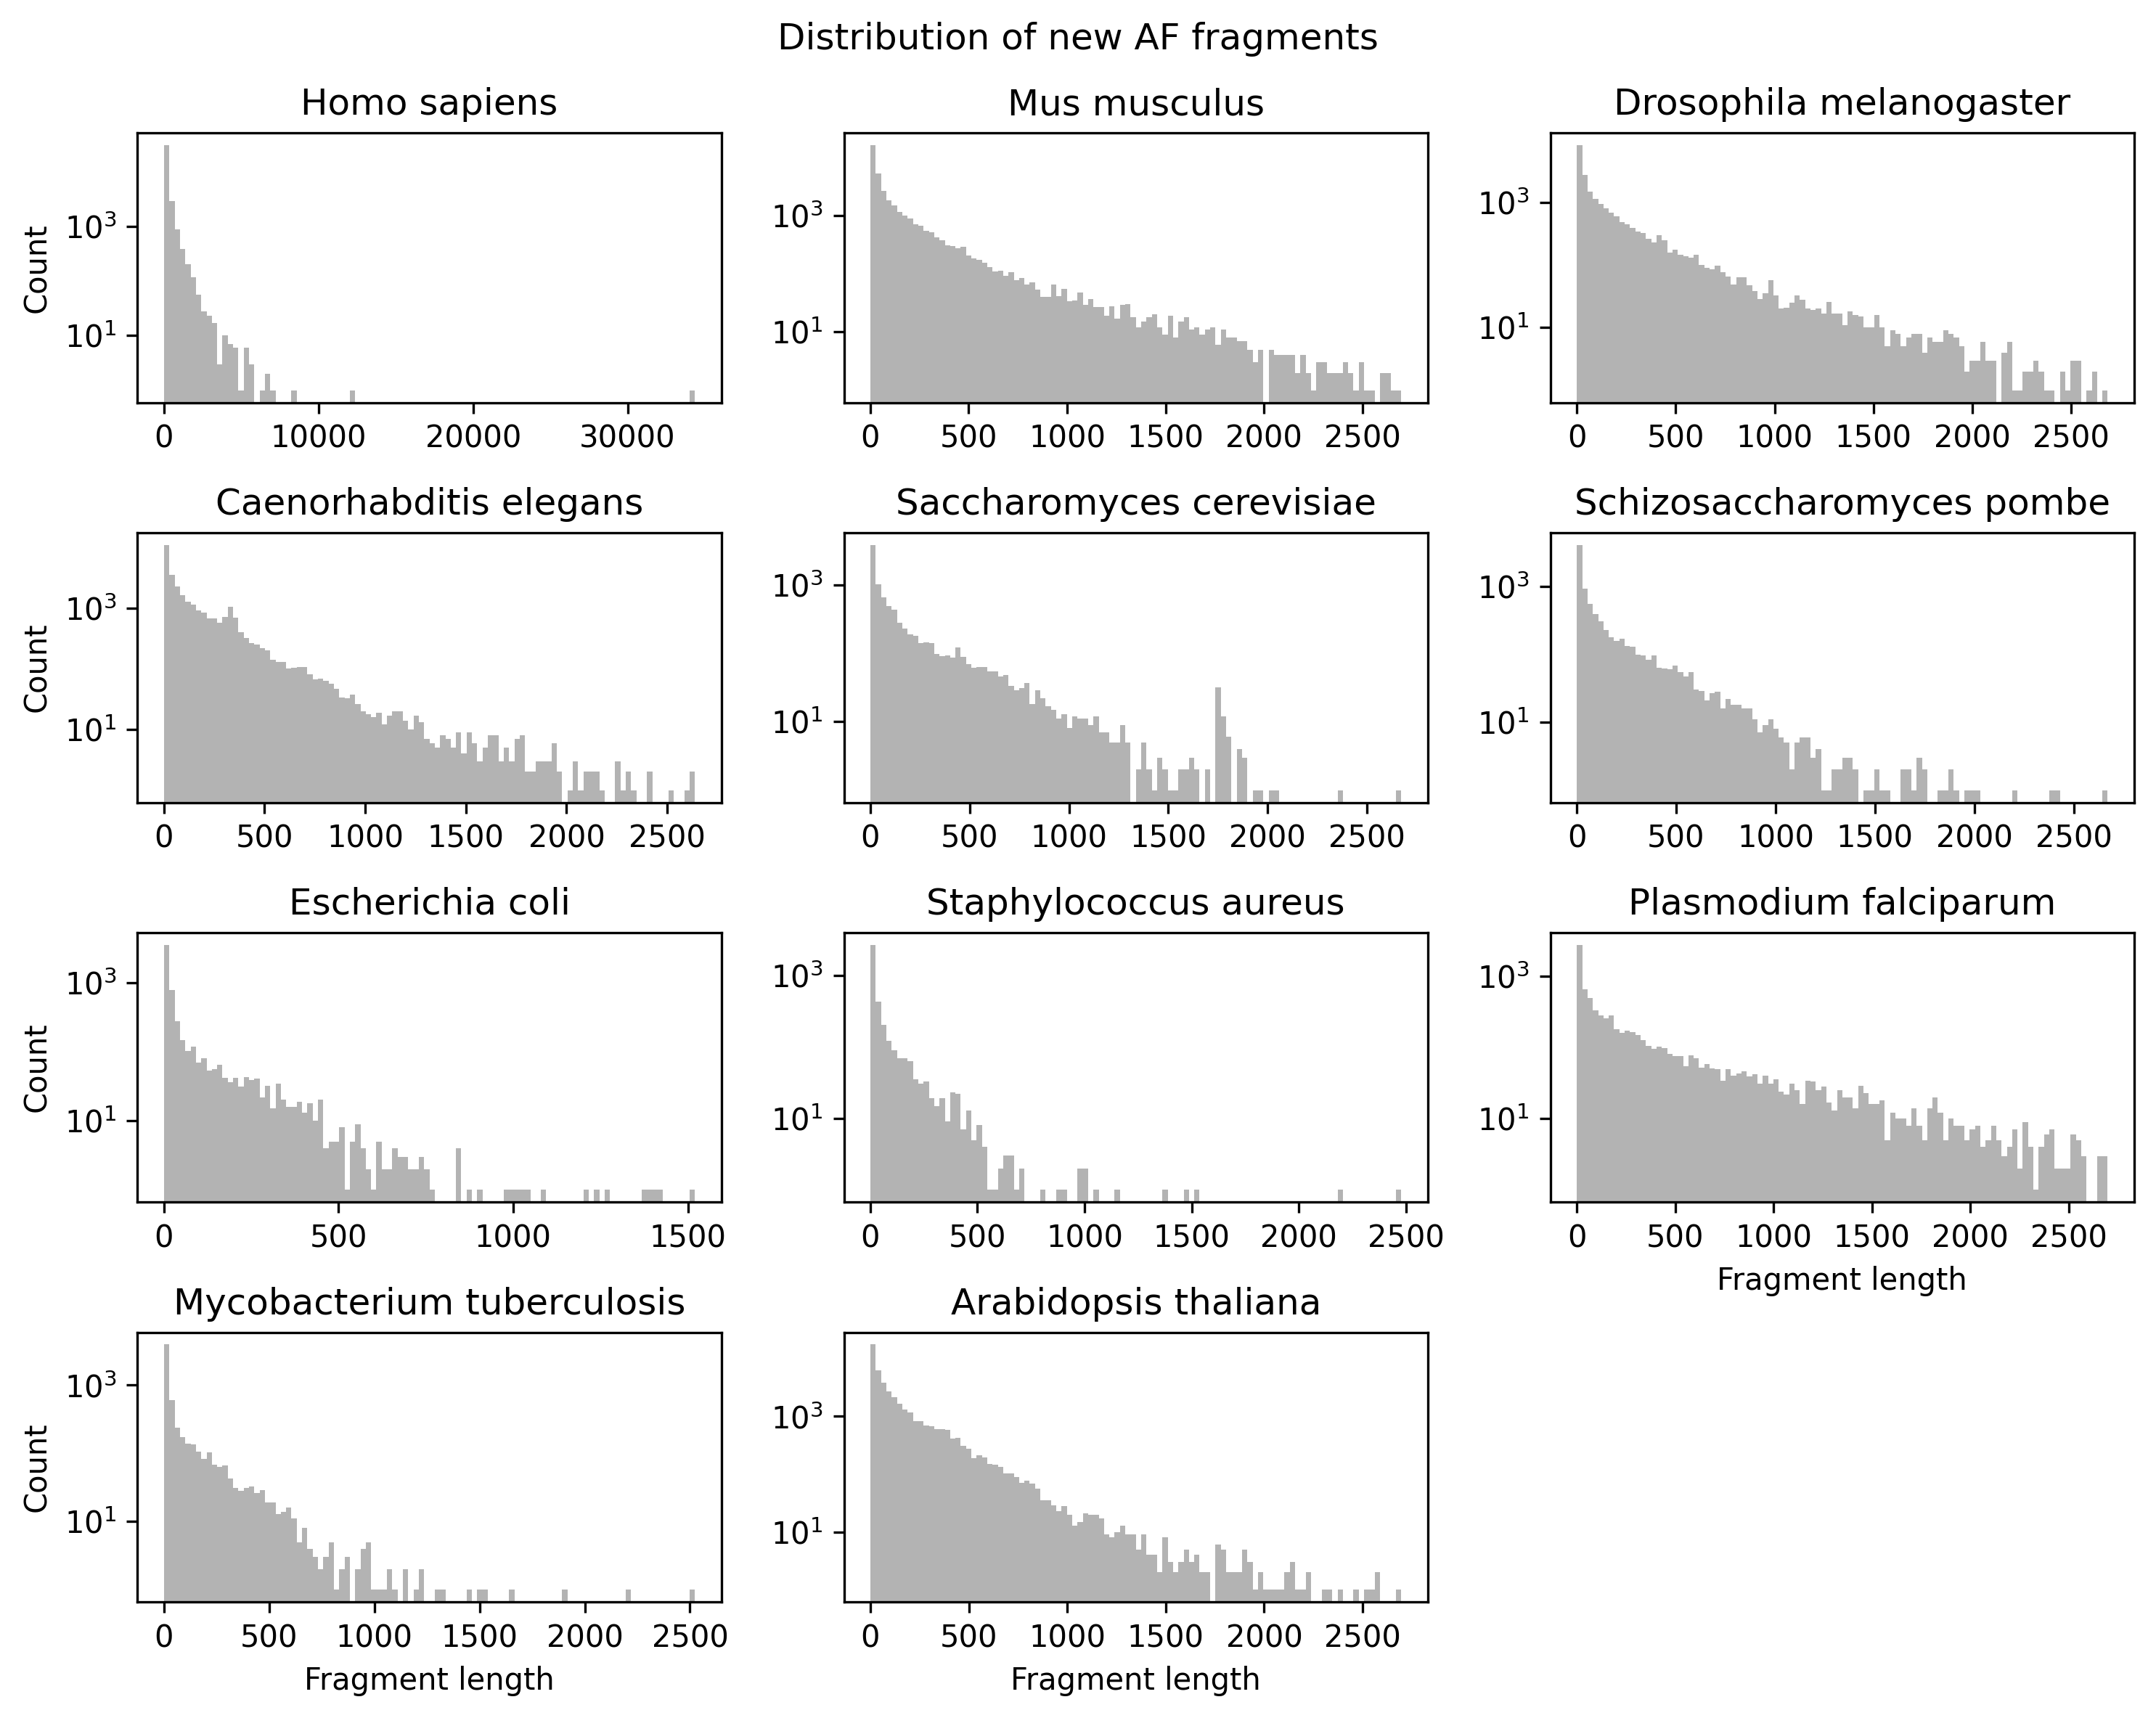

In [129]:
# Calculate distribution of new fragments
fig, axes = plt.subplots(4, 3, sharex=False, sharey=False)
axes.flat[-1].set_visible(False)
fig.set_size_inches(10, 8)
fig.set_dpi(300)

fig.suptitle('Distribution of new AF fragments')

for i in range(len(species)):
    specid = species[i]
    spname = spnames_formatted[i]
    newdata = data[specid]['newdata']
    ax_ = axes.flat[i]
    ii, ij = np.unravel_index(i, (4, 3))
    
    ax_.set_yscale('log')
    ax_.set_title(spname)
    hist_data = ax_.hist(newdata['length'], bins=100, alpha=0.5, color='dimgrey')
    
    if ij == 0:
        ax_.set_ylabel('Count')
        
    if ii == 3 or (ii, ij) == (2, 2):
        ax_.set_xlabel('Fragment length')

        plt.tight_layout()
plt.show()

<ipython-input-113-4040ceab675f>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(spnames_formatted)


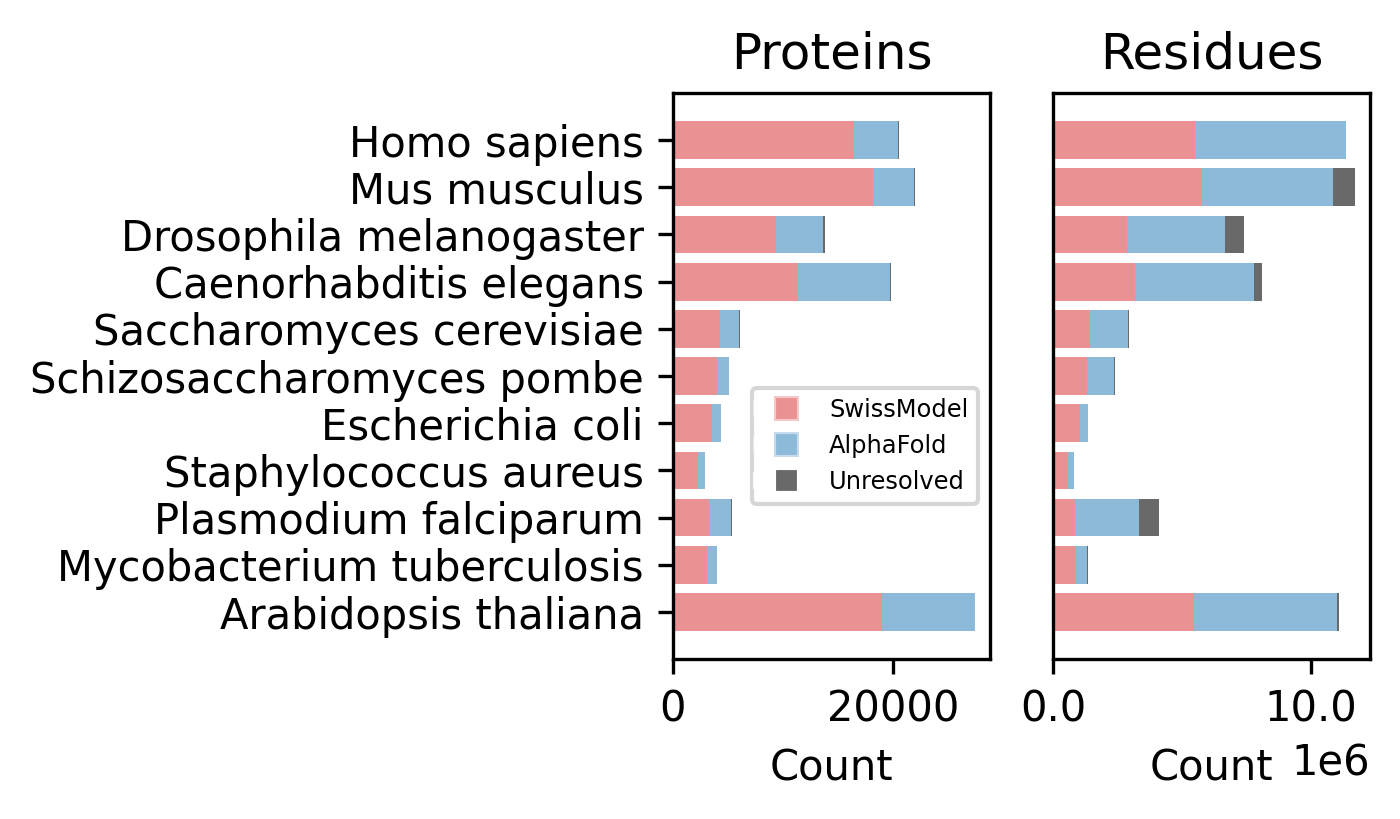

In [113]:
# format axes from https://stackoverflow.com/questions/43324152/python-matplotlib-colorbar-scientific-notation-base
class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
             self.format = r'$\mathdefault{%s}$' % self.format
# Setup plot
fig, axs = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(3, 2.5)
fig.set_dpi(300)

for i in range(nsp):
    specid = species[i]
    
    udata = data[specid]['udata']
    smdata = data[specid]['smdata']
    smtotal = data[specid]['smtotal']
    afdata = data[specid]['afdata']
    newdata = data[specid]['newdata']
    
    # Calc unique sets of Uniprot IDs
    uset = set(udata['Entry']) 
    smset = set(smdata['uniprot_ac'])
    afset = set(afdata['uniprot_ac'])
    
    nuset = len(uset)
    
    usmset = uset & smset
    nusmset = len(usmset)
    
    newafset = (uset & afset) ^ usmset
    nnewafset = len(newafset)
    nunresset = nuset - (nnewafset + nusmset)
    
    # Plot data
    ax = axs[0]
    
    ax.barh(i, nusmset, label='SwissModel', color='C3', alpha=0.5)
    ax.barh(i, nnewafset, left=nusmset, color='C0', alpha=0.5, label='AlphaFold_New')
    ax.barh(i, nunresset, left=(nusmset + nnewafset), color='dimgrey', label='Uniprot')
    
    ax = axs[1]

    ucompletel = np.sum(udata['Length'])
    afnewtotal = np.sum(newdata['length'])
    unresolved = ucompletel - (smtotal + afnewtotal)
    
    ax.barh(i, smtotal, label='SwissModel', color='C3', alpha=0.5)
    ax.barh(i, afnewtotal, left=smtotal, color='C0', alpha=0.5, label='AlphaFold_New')
    ax.barh(i, unresolved, left=(afnewtotal + smtotal), color='dimgrey', label='Unresolved')

ax = axs[0]
ax.set_yticklabels(spnames_formatted)
ax.set_title('Proteins')
ax.set_xlabel('Count')

custom_lines = [Line2D([0], [0], color='w', marker='s', markerfacecolor='C3', alpha=0.5, lw=4),
                Line2D([0], [0], color='w', marker='s', markerfacecolor='C0', alpha=0.5, lw=4),
                Line2D([0], [0], color='w', marker='s', markerfacecolor='dimgrey', lw=4)]

leg = ax.legend(custom_lines, ['SwissModel', 'AlphaFold', 'Unresolved'], fontsize='xx-small', loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.5))


ax = axs[1]
ax.set_yticks(range(nsp))    
ax.axes.yaxis.set_visible(False)
ax.xaxis.set_major_formatter(OOMFormatter(6, mathText=False))
ax.set_ylim(len(species), -1)
ax.set_title('Residues')
ax.set_xlabel('Count')


plt.show()

########################################
Homo sapiens
Total new confident residues: 2196842
Total new residues in AlphaFold (aa): 5879876
Confindent residues/Total new residues: 37.36%
########################################
Mus musculus
Total new confident residues: 1845716
Total new residues in AlphaFold (aa): 5108668
Confindent residues/Total new residues: 36.13%
########################################
Drosophila melanogaster
Total new confident residues: 1468213
Total new residues in AlphaFold (aa): 3807461
Confindent residues/Total new residues: 38.56%
########################################
Caenorhabditis elegans
Total new confident residues: 2368025
Total new residues in AlphaFold (aa): 4612372
Confindent residues/Total new residues: 51.34%
########################################
Saccharomyces cerevisiae
Total new confident residues: 692790
Total new residues in AlphaFold (aa): 1472953
Confindent residues/Total new residues: 47.03%
########################################
Sc

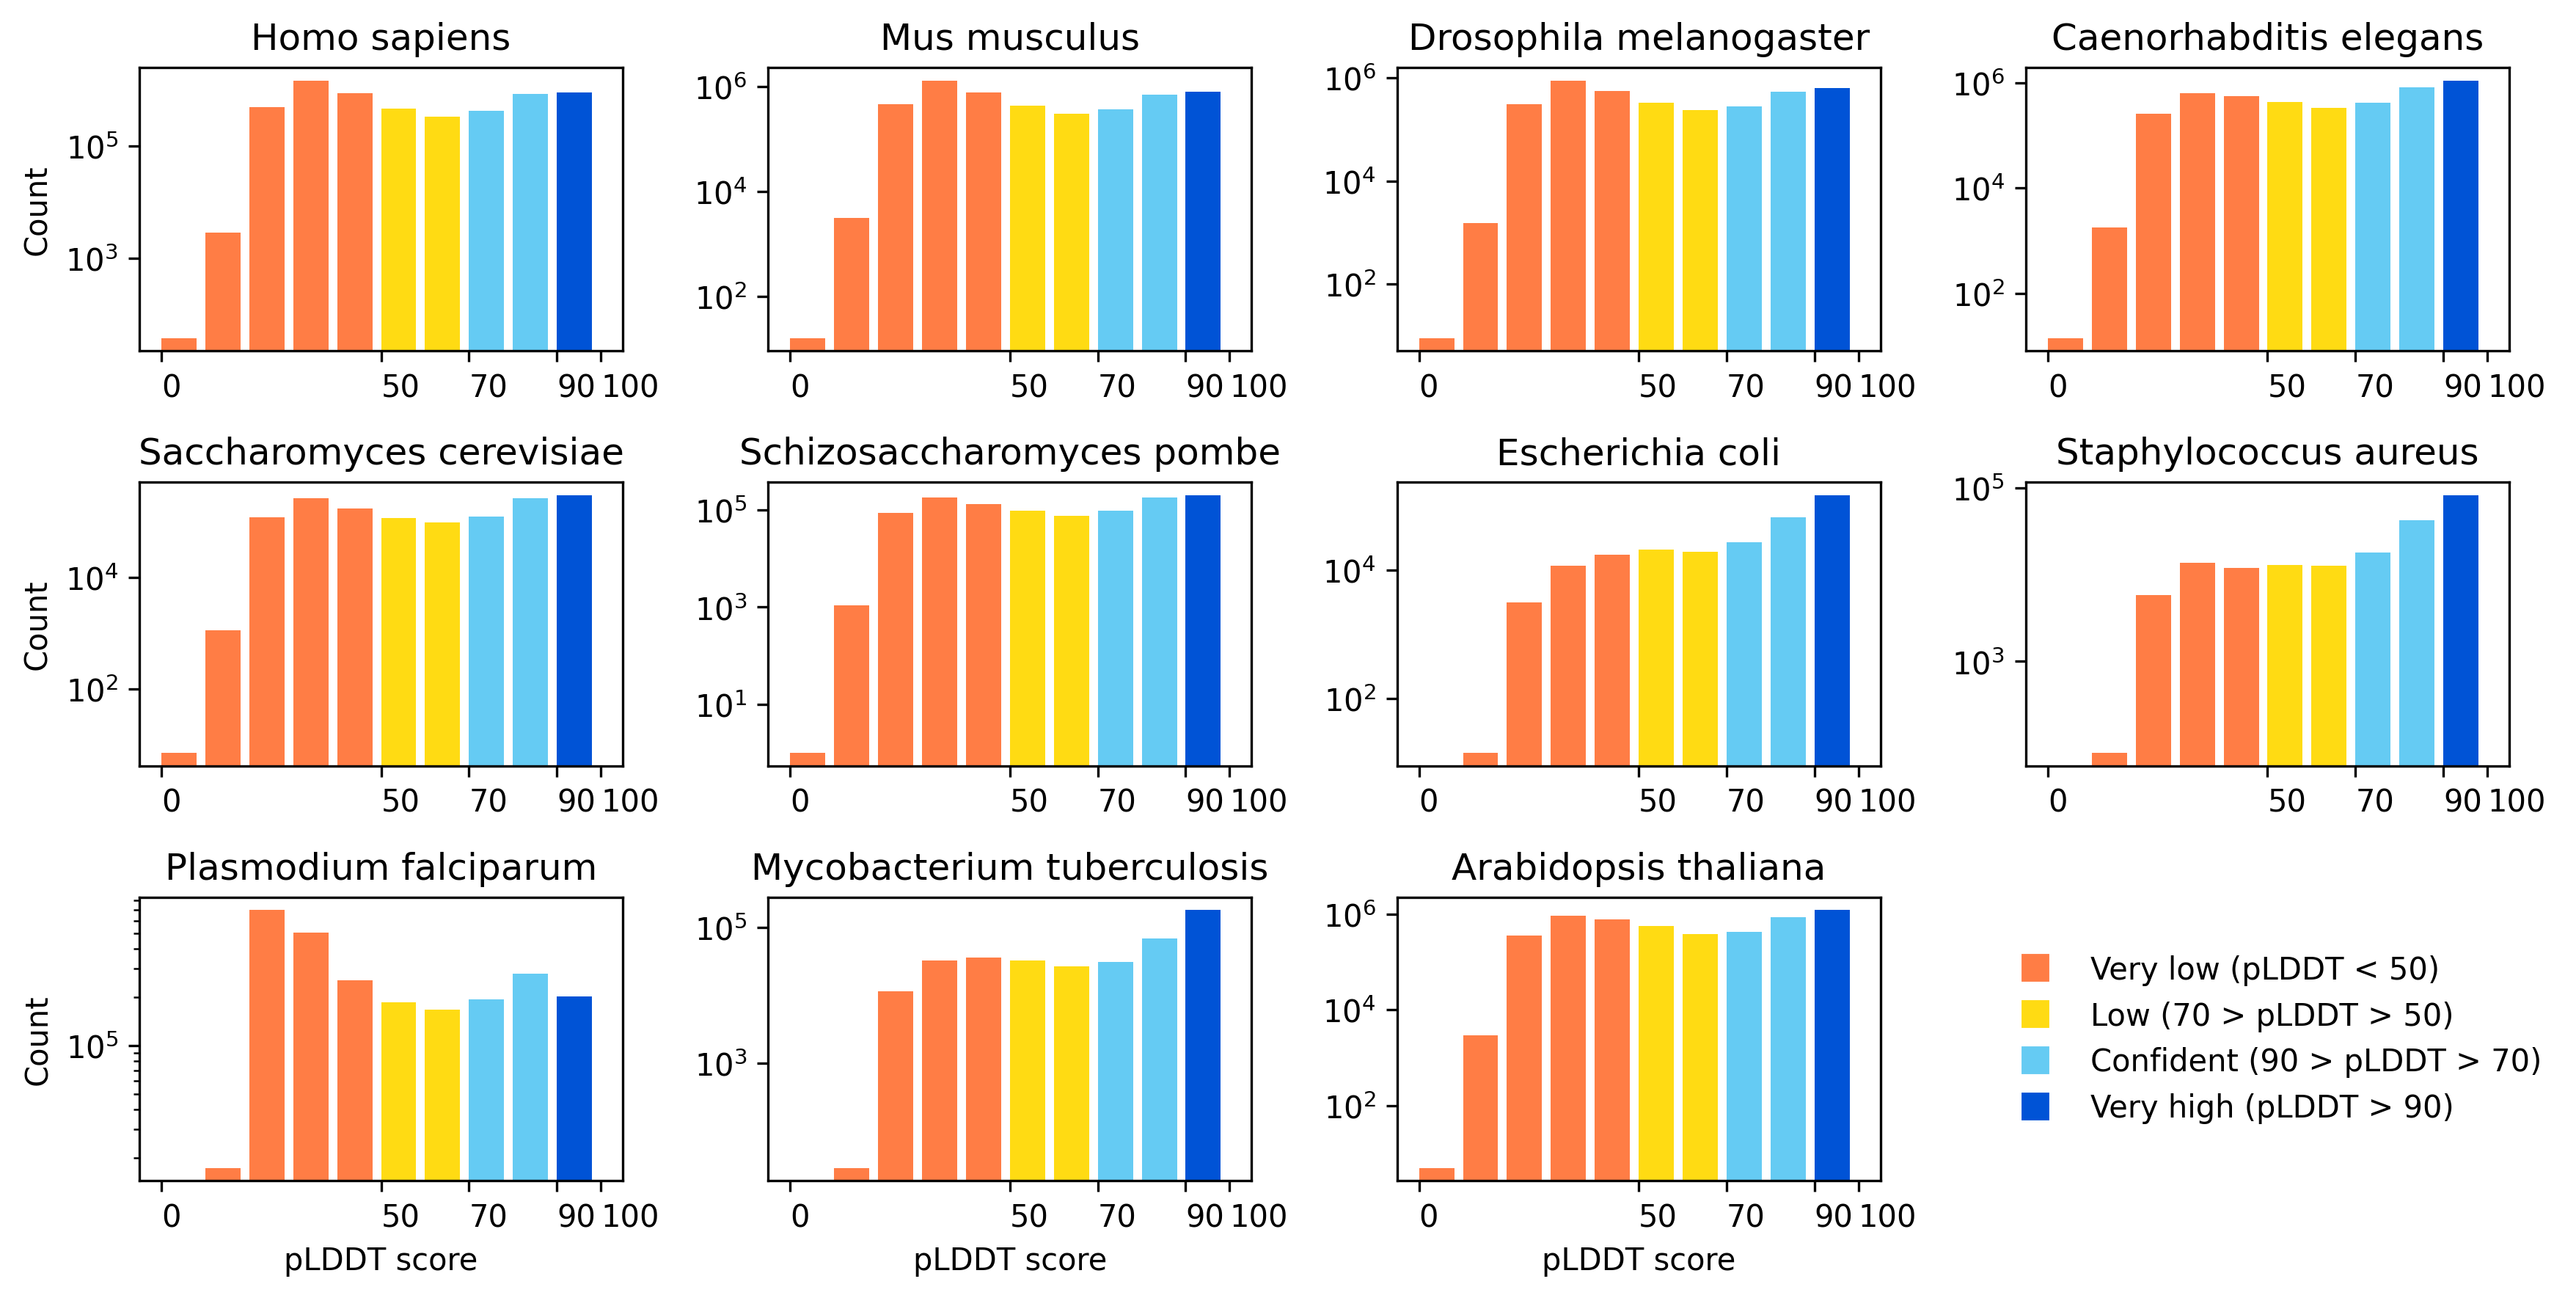

In [114]:
scoreticks = np.linspace(0, 100, 11)

# Color distibution according to AlphaFold colors
cvlow = '#ff7d45'
clow = '#ffdb13'
cconf = '#65cbf3'
cvhigh = '#0053d6'

fig, axes = plt.subplots(3, 4)
fig.set_size_inches(12, 6)
fig.set_dpi(300)

for i in range(nsp):
    specid = species[i]
    spname = spnames_formatted[i]
    newdata = data[specid]['newdata']
    
    ii, ij = np.unravel_index(i, (3, 4))
    
    ax_ = axes.flat[i]
    ax_.set_yscale('log')
    ax_.set_title(spname)
    ax_.set_xticks([0, 50, 70, 90, 100])
    ax_.set_xticklabels([0, 50, 70, 90, 100], ha='left')
    
    # Collect all individual pLDDT values into one array
    plddtall_ = list()
    for index, row in newdata.iterrows():
        plddtall_.extend(row['pLDDT'])
    plddtall = np.array(plddtall_)
    
    afnewtotal = np.sum(newdata['length'])
    
    print('#' * 40)
    print(spname)
    plddtall_conf = len(plddtall[plddtall > 70])
    print('Total new confident residues: %d' % plddtall_conf)
    print('Total new residues in AlphaFold (aa): %d' % afnewtotal)
    print('Confindent residues/Total new residues: %.2f%%' % (plddtall_conf / afnewtotal * 100.0))
    
    N, bins, patches = ax_.hist(plddtall, bins=scoreticks, width=8)
    
    if ij == 0:
        ax_.set_ylabel('Count')
        
    if ii == 2:
        ax_.set_xlabel('pLDDT score')

    for i in range(5):
        patches[i].set_facecolor(cvlow)
    for i in range(5, 7):
        patches[i].set_facecolor(clow)
    for i in range(7, 9):
        patches[i].set_facecolor(cconf)
    for i in range(9, 10):
        patches[i].set_facecolor(cvhigh)

# axes.flat[-1].set_visible(False)

ax = axes.flat[-1]

custom_lines = [Line2D([0], [0], color='w', marker='s', markersize=10, markerfacecolor=cvlow, lw=4),
                Line2D([0], [0], color='w', marker='s', markersize=10, markerfacecolor=clow,  lw=4),
                Line2D([0], [0], color='w', marker='s', markersize=10, markerfacecolor=cconf, lw=4),
                Line2D([0], [0], color='w', marker='s', markersize=10, markerfacecolor=cvhigh, lw=4)
               ]

ax.legend(
    custom_lines, ['Very low (pLDDT < 50)', 'Low (70 > pLDDT > 50)', 'Confident (90 > pLDDT > 70)', 'Very high (pLDDT > 90)'], 
    fontsize='medium', 
    loc='center left', 
    bbox_to_anchor=(-0.1, 0.5),
    frameon=False,
)

ax.axis('off')

plt.tight_layout()
plt.show()

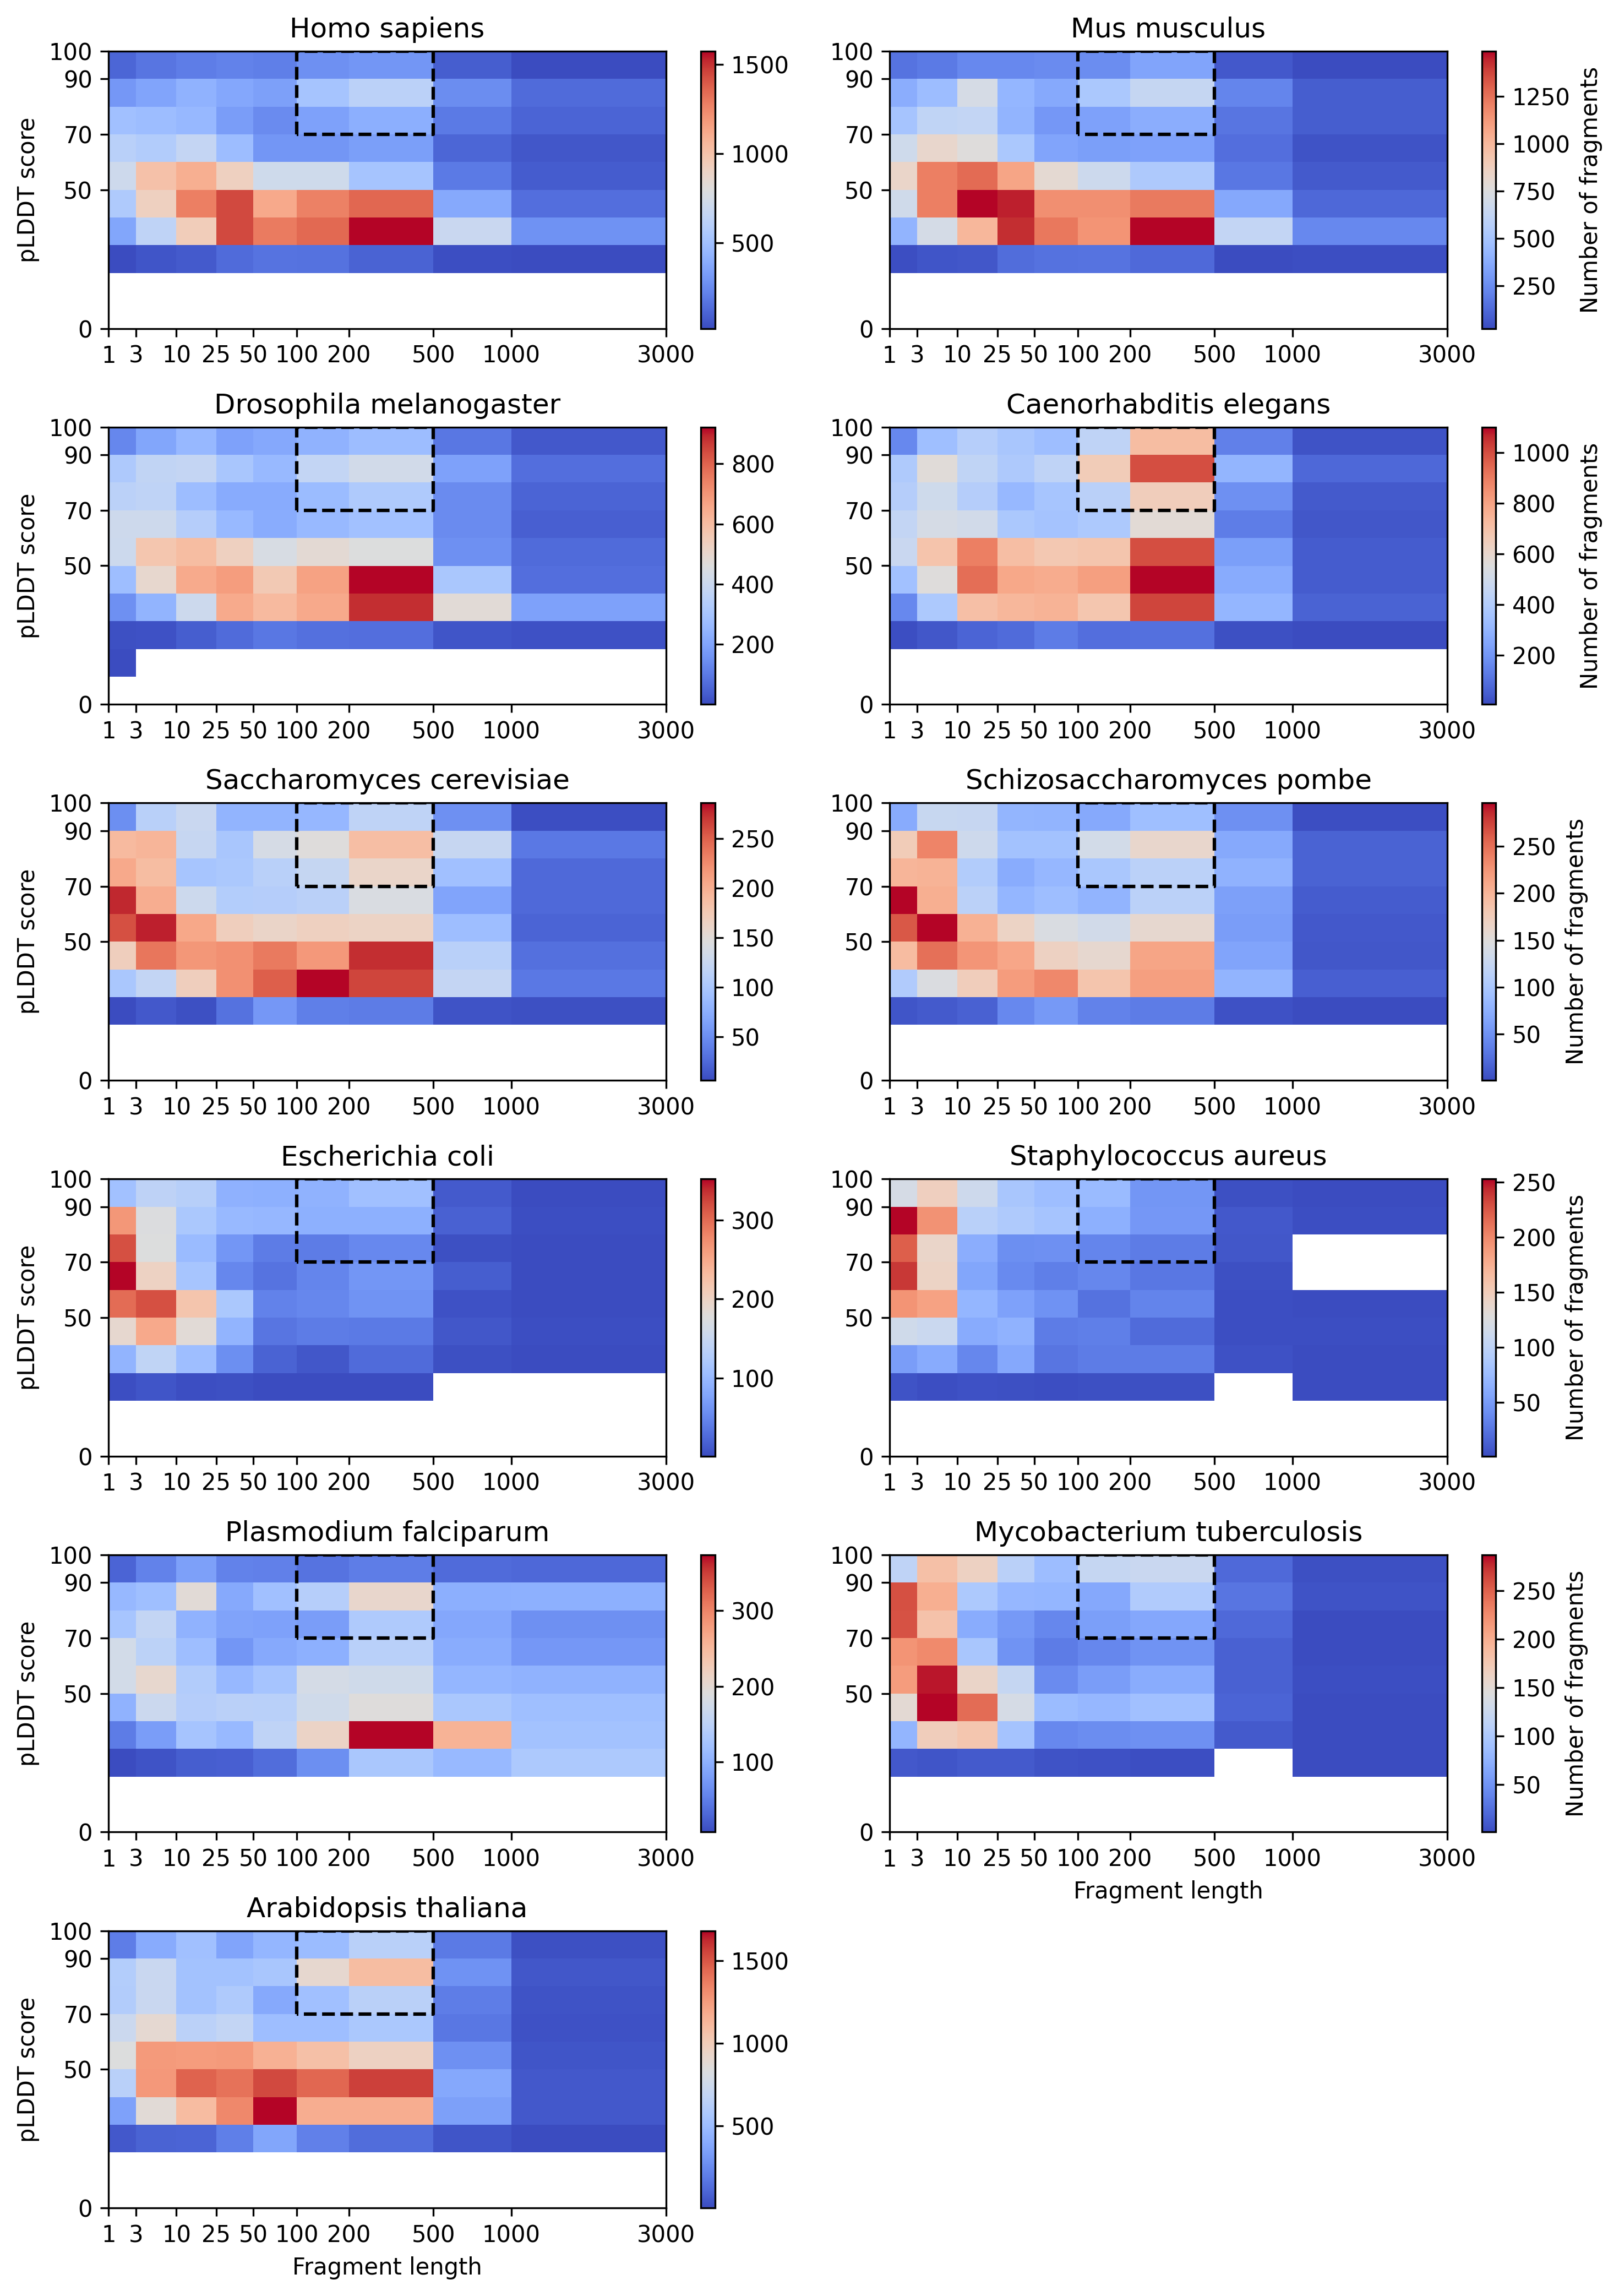

In [116]:
# Scale axis as in https://matplotlib.org/stable/gallery/scales/scales.html

# Function x**(1/2)
def forward(x):
    return x**(1/4)

def inverse(x):
    return x**4


fig, axs = plt.subplots(6, 2)
fig.set_size_inches(10, 14)
fig.set_dpi(300)
axs.flat[-1].set_visible(False)

# xticks = [1, 3, 10, 25, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 35000]
# xticks = [1, 3, 10, 25, 50, 100, 200, 500, 1000, 2500, 10000, 35000]
xticks = [1, 3, 10, 25, 50, 100, 200, 500, 1000, 3000]

for i in range(len(species)):
    specid = species[i]
    spname = spnames_formatted[i]
    newdata = data[specid]['newdata']
    ax_ = axs.flat[i]
    ii, ij = np.unravel_index(i, (6, 2))

    ax_.set_xscale('function', functions=(forward, inverse))

    hist = ax_.hist2d(
        newdata['length'], 
        newdata['pLDDT_med'], 
        cmap='coolwarm', cmin=1,
        bins=[xticks, np.linspace(0, 100, 11)])

    cb = fig.colorbar(hist[3], ax=ax_)
    if ij == 1:
        cb.set_label('Number of fragments')
    ax_.set_xticks(xticks)
    ax_.set_yticks([0, 50, 70, 90, 100])
    ax_.set_xticklabels(xticks, rotation=0, verticalalignment='top', horizontalalignment='center')
    
    if ij == 0:
        ax_.set_ylabel('pLDDT score')
    
    if (ii, ij) == (5, 0) or (ii, ij) == (4, 1):
        ax_.set_xlabel('Fragment length')
    
    ax_.set_title(spname)
    
    ax_.plot((100, 100, 500, 500, 100), (70, 100, 100, 70, 70), ls='--', color='black')
    # ax_.set_title('Distribution of median pLDDT score per fragment')
    
plt.tight_layout()
plt.show()

In [264]:
# Prepare mapping of Prosite rules to Prosite domains
pr2ps = dict()

# 
prurl = 'https://ftp.expasy.org/databases/prosite/prorule.dat'

# Download SwissModel repo metadata
preq = requests.get(prurl)
b_ = BytesIO(prreq.content)

pr, ps = None, None
isrec = False
for line in b_.readlines():
    line_ = line.decode('utf-8')
    if line_[:2] == "//":
        isrec = False
                        
    if line_[:2] == 'AC':
        isrec = True
        line__ = re.sub('\s+', ';', line_).split(';')
        pr = line__[1]
        ps = None
        
    if line_[:2] == 'DC':
        line__ = re.sub('\s+', ';', line_).split(';')
        if line__[1] != 'Domain':
            isrec = False
            pr = None
        
    if (line_[:2] == 'TR') and (isrec is True):
        line__ = re.sub('\s+', ';', line_).split(';')
        
        if line__[1] != 'PROSITE':
            continue
        
        ps = line__[3]
        
        if ps[:2] != 'PS':
            continue
        
        if pr is not None and ps is not None:
            pr2ps[pr] = ps

In [308]:
# Look if there any domain-level enrichment in new fragments
newfrags = 0
for i in range(nsp):
    
    specid = species[i]
    udata = data[specid]['udata']
    newdata = data[specid]['newdata']
    
    
    frags_ = newdata[(newdata['length'] >= 100) &
                     (newdata['length'] < 500) &
                     (newdata['pLDDT_med'] > 70)
                    ]
    
    newfrags += len(frags_)
    
    fragdomains_ = list()

    for index, row in tqdm.tqdm(frags_.iterrows(), total=len(frags_)):
        ac = row['uniprot_ac']
        udata_ = udata[udata['Entry'] == ac]
        b = row['from']
        e = row['to']
        udomains = udata_['Domain [FT]'].values[0]

        if type(udomains) is not str:
            continue

        # Look for annotated domains from the Uniprot data
        domains_ = udomains.split(';')
        for i in range(len(domains_)):
            v = domains_[i]
            if v[:6] == 'DOMAIN':
                v_ = v.split(' ')[1]
                be_ = v_.split("..")
                b_ = int(re.sub("[^0-9]", '', be_[0]))
                e_ = int(re.sub("[^0-9]", '', be_[1]))
                

                flag = False
                if b_ <= b and e_ >= b:
                    flag = True
                elif b_ <= e and e_ >= e:
                    flag = True
                elif b_ >= b and e_ <= e:
                    flag = True

                if flag is True:
                    domain_ = domains_[i + 1].strip()
                    domain_ = re.sub('"', '', domain_)
                    domain_ = re.sub('/note=', '', domain_)
                    
                    ps_ = None
                    try:
                        pr_ = domains_[i + 2].strip('"').split(':')[-1]
                    
                        if pr_[:2] == 'PR':
                            ps_ = pr2ps[pr_]
                    except:
                        pass

                    d_ = {
                        'ac': ac,
                        'from': b,
                        'to': e,
                        'domain': domain_,
                        'prosite': ps_,
                        'from_d': b_,
                        'to_d': e_,
                        'pLDDT_med': row['pLDDT_med'],
                        'sequence': row['sequence']
                    }
                    fragdomains_.append(d_)
    
    data[specid]['fragdomains'] = pd.DataFrame(fragdomains_)

100%|██████████| 4284/4284 [00:06<00:00, 654.20it/s]


In [281]:
# Count actual counts
fragdomainsc_all = dict()

for i in range(nsp):
    
    specid = species[i]
    fragdomains = data[specid]['fragdomains']

    fragdomainsc_ = Counter(fragdomains['prosite'])
    fragdomainsc = pd.DataFrame(fragdomainsc_.items(), columns=['prosite', 'count'])
    fragdomainsc = fragdomainsc.sort_values(by='count', ascending=False)
    data[specid]['domain_counter'] = fragdomainsc

In [298]:
# Check InterPro domains 

ipurl = 'https://www.ebi.ac.uk/interpro/api/entry/profile/%s'

# Check only topN domains
topN = 20
for i in range(nsp):
    specid = species[i]
    domcounter = data[specid]['domain_counter']
    unknown_ = list()
    
    for index, row in domcounter[:topN].iterrows():
        if row['prosite'] == None:
            continue
            
        ipurl_ = ipurl % row['prosite']
        ipreq = requests.get(ipurl_)
        if ipreq.status_code == 200:
            ipdata = ipreq.json()
            sc = ipdata['metadata']['counters']['structures']
            if sc == 0:
                d_ = {
                    'prosite': row['prosite'],
                    'interpro': ipdata['metadata']['integrated'],
                    'name': ipdata['metadata']['name']['short'],
                    'long_name': ipdata['metadata']['name']['name'],
                    'count': row['count'],
                    'trRosetta': ipdata['metadata']['counters']['structural_models']['trRosetta'],
                }
                unknown_.append(d_)
                
    unknown = pd.DataFrame(unknown_)
                
    data[specid]['unknown'] = unknown

In [304]:
for i in range(nsp):
    specid = species[i]
    spname = spnames_formatted[i]
    unknown = data[specid]['unknown']
    if len(unknown) > 0:
        print(spname)
        print(unknown)

Homo sapiens
   prosite   interpro name           long_name  count  trRosetta
0  PS50922  IPR006634  TLC  TLC domain profile      7          0
1  PS51303  IPR010442  PET  PET domain profile      6          0
Mus musculus
   prosite   interpro    name              long_name  count  trRosetta
0  PS51225  IPR008253  MARVEL  MARVEL domain profile     14          0
1  PS50922  IPR006634     TLC     TLC domain profile      9          0
Drosophila melanogaster
   prosite   interpro            name                               long_name  \
0  PS51155  IPR000618  CHIT_BIND_RR_2  Chitin-binding type R&R domain profile   
1  PS51381  IPR010796           C2_B9               C2 B9-type domain profile   
2  PS51549  IPR019545            DM13                     DM13 domain profile   
3  PS51303  IPR010442             PET                      PET domain profile   

   count  trRosetta  
0      4          0  
1      2          0  
2      1          0  
3      1          0  
Caenorhabditis elegans
   

In [307]:
data[9606]['newdata'][data[9606]['newdata']['length'] > 10000]

,uniprot_ac,fragnum,from,to,length,pLDDT,pLDDT_min,pLDDT_med,pLDDT_max,sequence
4637,Q8WXI7,0,1,12075,12075,"[32.72, 39.19, 30.65, 46.97, 41.57, 39.2, 35.0...",25.05,38.70,93.53,MLKPSGLPGSSSPTRSLMTGSRSTKATPEMDSGLTGATLSPKTSTG...
34382,Q8WZ42,0,1,34350,34350,"[56.65, 78.09, 86.55, 88.68, 92.21, 93.68, 93....",38.81,51.88,88.45,MTTQAPTFTQPLQSVVVLEGSTATFEAHISGFPVPEVSWFRDGQVI...


In [311]:
# Save all the data
with open('/tmp/dump_20210815.dump', 'wb') as f:
    dill.dump(data, f)